# **ESEIAAT - Codificació Multimèdia**
## **Lab 1: Intro**

2021 - Josep Ramon Morros - [GPI](https://imatge.upc.edu/web/) @ [IDEAI](https://ideai.upc.edu/en) Research group // ESEIAAT



---


### Write here the names of the group members

**Name 1**: Josep Esquerrà Bayo

**Name 2**:

You can answer in Catalan, Spanish or English

---



## 1. Motivation

The objective of this session is to analyze the main characteristics of the audiovisual signals and the main concepts of a coding system.

We will be using the some additional images and videos. First of all download them from ATENEA and upload them to the Colaboratory notebook using the menu on the left (click the folder icon, upload the cm_l1.zip file). Wait until the upload is complete, it may take some time.

*Decompress* the zip file to use its contents:`


In [11]:
!unzip cm_lab1.zip
!rm cm_lab1.zip

Archive:  cm_lab1.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of cm_lab1.zip or
        cm_lab1.zip.zip, and cannot find cm_lab1.zip.ZIP, period.


Consider a network with a speed of 6Mbps. We want to stream audio and video. The audio is de CD quality (sampling frequency 44100 Hz, 16 bits/sample, 2 channels), which results in a bitrate of:

In [12]:
audio_rate = 44100 * 16 * 2
print('Bitrate = {} bits/s'.format(audio_rate))

Bitrate = 1411200 bits/s


For this audio rate, the maximum video resolution (area) that can be obtained is 7640 pixels, for a frame-rate of 25 fps. This value is obtained knowing that each frame has 3 channels, and each channel is made up of pixels values range from 0 to 255. You can check this with the following calculations:


In [13]:
resolution = 7640;
video_rate= 25*resolution*3*8
total_rate = audio_rate + video_rate
print('Total bitrate = {} bits/s ~ 6 Mbps'.format(total_rate))

Total bitrate = 5995200 bits/s ~ 6 Mbps


If we have a display with a square aspect ratio, 7640 pixels correspond to an image of about 87x87 pixels. In a 16x9 aspect ratio display, this results in a 117x65 pixel image.

These resulutions will appear tiny in a modern computer monitor, with resolutions up to 1960x1080 or larger.


If we want to improve the resolution and therefore improve the quality, we will need to compress the data. To do this, the usual scheme consists of three blocks: signal space transformation, quantification, and entropic coding.

First, we will analyze some properties that characterize image and audio signals. We will then take advantage of these properties using the proposed coding scheme.

## 2. Signal model
### 2.1 Image
#### 2.1.1 Spatial redundancy

In the spatial domain, there is usually a high correlation between pixels (samples) that are close. That is, the values of neighboring samples are usually similar to each other. To illustrate this property, upload the image baboon.jpg.

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from lab1.code.display_images import display_image, display_images

ModuleNotFoundError: No module named 'lab1'

In [15]:
baboon = cv2.imread('lab1/images/baboon.jpg')
baboon_gray = cv2.cvtColor(baboon, cv2.COLOR_BGR2GRAY) # convert to gray

display_image (baboon_gray, 'Baboon', size = 0.5)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Compute the correlation coefficient between adjacent pairs of pixels:

In [ ]:
dbaboon  = baboon_gray.astype(float).flatten()
corr_coef = np.corrcoef(dbaboon[0:-1],dbaboon[1:])
print ('Correlation coefficient = {:.3f}'.format(corr_coef[0][1]))


Now calculate the 2D histogram of the adjacent pairs of pixels, and comment on the result:

In [ ]:
xedges = np.linspace(0,250,251)
yedges = np.linspace(0,250,251)
histmat, xedges, yedges = np.histogram2d(dbaboon[1:], dbaboon[0:-1], bins=(xedges, yedges))
plt.imshow(histmat, interpolation='nearest', origin='lower', cmap = 'jet',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel('Amplitude of current pixel')
plt.ylabel('Amplitude of adjacent pixel')
plt.title('Adjacent pixels 2D Histogram')

plt.show()

Comment the results (histogram of adjacent pixels and correlation coefficient):

<font color=red>**Q1 - Answer**:  </font><br>
<font color=blue>
the histogram show us the relation between adjacent pixels. The results indicate there's a huge relation with pixels around values as 120 and 180 over 255.
</font>

#### 2.1.2. Inter-channel redundancy

A true color image is represented using three channels.
Usually, when working with multispectral images, there is a strong correlation between channels. This can be clearly seen in the Baboon image and its RGB components:

In [ ]:
baboon_rgb  = cv2.cvtColor(baboon, cv2.COLOR_BGR2RGB)   # Convert to RGB
display_images(baboon_rgb,    baboon[:,:,0], 'Baboon',    'B Channel', size = 0.5)
display_images(baboon[:,:,1], baboon[:,:,2], 'G Channel', 'R Channel', size = 0.5)

A common technique for analyzing the redundancy shared between different channels is to compare each pixel in a pair of channels (R-channel and G-channel, for example). We first calculate the correlation coefficient between corresponding pixels (in the same position) in the two channels:

In [ ]:
corr_coef = np.corrcoef(baboon_rgb[:,:,0].flatten().astype(float), baboon_rgb[:,:,1].flatten().astype(float))
print ('Correlation coefficient = {:.3f}'.format(corr_coef[0][1]))

Now compute the 2D histogram of the corresponding pixels and
comment on the results:

In [ ]:
xedges = np.linspace(0,255,256)
yedges = np.linspace(0,255,256)
fbaboon_rgb = baboon_rgb.astype(float)
histmat, xedges, yedges = np.histogram2d(fbaboon_rgb[:,:,0].flatten(), fbaboon_rgb[:,:,1].flatten(), bins=(xedges, yedges))
plt.imshow(histmat, interpolation='nearest', origin='lower', cmap = 'jet',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel('R channel')
plt.ylabel('G channel');
plt.title('R-G channels 2D Histogram')

plt.show()


<font color=red>**Q2 - Answer**:  </font><br>
<font color=blue>
on every pixel, there's a huge relation between red and green channel over values 50-200. There are a few points out of it, maybe because the differences of the channels on the mouse of the character.
</font>

Consider the same image in another color space (YCbCr) and perform the same operation as before:


In [ ]:
baboon_ycrcb = cv2.cvtColor(baboon, cv2.COLOR_BGR2YCR_CB)

display_images(baboon_rgb, baboon_ycrcb[:,:,0], 'Color image', 'Y Channel', size=0.5)
display_images(baboon_ycrcb[:,:,2], baboon_ycrcb[:,:,1], 'Cb channel', 'Cr Channel', size=0.5)

Compute the correlation coefficient:

In [ ]:
corr_coef_YCb = np.corrcoef(baboon_ycrcb[:,:,0].flatten().astype(float), baboon_ycrcb[:,:,2].flatten().astype(float))
corr_coef_YCr = np.corrcoef(baboon_ycrcb[:,:,0].flatten().astype(float), baboon_ycrcb[:,:,1].flatten().astype(float))

print ('Correlation coefficient Y-Cb = {:.3f}'.format(corr_coef_YCb[0][1]))
print ('Correlation coefficient Y-Cr = {:.3f}'.format(corr_coef_YCr[0][1]))

Compute the 2d histograms of chanels Y and Cb and channels Y and Cr:

In [ ]:
fbaboon_ycrcb = baboon_ycrcb.astype(float)
histmat1, xedges, yedges = np.histogram2d(fbaboon_ycrcb[:,:,0].flatten(), fbaboon_ycrcb[:,:,2].flatten(), bins=(xedges, yedges))
histmat2, xedges, yedges = np.histogram2d(fbaboon_ycrcb[:,:,0].flatten(), fbaboon_ycrcb[:,:,1].flatten(), bins=(xedges, yedges))

fig, ax = plt.subplots(1,2)
plt.grid(False)
h = ax[0].imshow(histmat1, interpolation='nearest', origin='lower', cmap = 'jet',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

hsep = 0.1
size = 1.0
dpi = h.figure.get_dpi()/size
h.figure.set_figwidth(histmat1.shape[1] / dpi)
h.figure.set_figheight(histmat1.shape[0] / dpi)
h.figure.canvas.resize(histmat1.shape[1] + 1, histmat1.shape[0] + 1)
h.axes.set_position([0, 0, 1, 1])

ax[0].set_xlabel('Y channel')
ax[0].set_ylabel('Cb channel');
ax[0].set_title('Y-Cb channels 2D Histogram')
h = ax[1].imshow(histmat2, interpolation='nearest', origin='lower', cmap = 'jet',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
dpi = h.figure.get_dpi()/size

h.figure.set_figwidth(histmat2.shape[1] / dpi)
h.figure.set_figheight(histmat2.shape[0] / dpi)
h.figure.canvas.resize(histmat2.shape[1] + 1, histmat2.shape[0] + 1)
h.axes.set_position([1+hsep, 0, 1, 1])

ax[1].set_xlabel('Y channel')
ax[1].set_ylabel('Cr channel');
ax[1].set_title('Y-Cr channels 2D Histogram')

plt.show()

Discuss the differences between the correlations of the pixels in both color spaces. In which **color space** are the channels most correlated?

<font color=red>**Q3 - Answer**:  </font><br>
<font color=blue>
in the frist picture, there's a few relation between all the Cb channel til 200 value and Y channel between 100-150.

for other side, there's a huge relation between all the Cr channel til 200 value and Y channel between 100-150. Maybe because the beard of the charracter, appeared a point in the middle-right side of the picture.
</font>

However, if we compare the correlations between the chrominance channels (Cb and Cr) of the YCbCr image we can observe a strong correspondence between components. First calculate the correlation coefficient:

In [ ]:
corr_coef_CbCr = np.corrcoef(baboon_ycrcb[:,:,2].flatten().astype(float), baboon_ycrcb[:,:,1].flatten().astype(float))
print ('Correlation coefficient Cb-Cb = {:.3f}'.format(corr_coef_CbCr[0][1]))

Now calculate the 2D histogram of the Cb and Cr channels:

In [ ]:
histmat3, xedges, yedges = np.histogram2d(fbaboon_ycrcb[:,:,2].flatten(), fbaboon_ycrcb[:,:,1].flatten(), bins=(xedges, yedges))

plt.imshow(histmat3, interpolation='nearest', origin='lower', cmap = 'jet',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel('Cb channel')
plt.ylabel('Cr channel');
plt.title('Cr-Cb channels 2D Histogram')

plt.show()

Despite the fact that the chrominance channels are not independent of each other, the color space transformation is equally useful. Why?
Before answering this question, it is better to solve subsection 2.1.4

<font color=red>**Q4 - Answer**:  </font><br>
<font color=blue>
It is usefull to select which values of the histogram between the two channels we can use and which one we can erase. In this case, we can keep the center value and eliminate the once around
</font>

#### 2.1.3. Temporal redundancy

When working with videos, frames that are temporarily close share a lot of information. In particular, the values of the pixels that are in the same position in consecutive frames show a high correlation. In this section we will analyze spatial redundancy using differences between frames.
The Frame Difference between two images I (n) and I (n + a) is calculated as the difference between the two images:
```
Df[I(n),I(n+1)] = |I(n)-I(n+1)|
```

In [ ]:
im1 = cv2.imread('lab1/images/00002979.jpg')
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)

im2 = cv2.imread('lab1/images/00002981.jpg')
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

display_images (im1, im2, 'Frame n', 'Frame n+2', size=0.5)

In [ ]:
frame_dif = np.abs(im1.astype(int)-im2.astype(int)).astype(np.uint8)
display_image(frame_dif, 'Frame Difference', size=1.0)

Discuss the meaning of the resulting Frame Difference in terms of temporal redundancy. What is the meaning of the white areas and the black areas? Include the concept of correlation in your answer.


<font color=red>**Q5 - Answer**:  </font><br>
<font color=blue>
In the picture he can see the substraction between frame 1 and frame 0. ii is something like the derivation. We can see how the players are moving between frames clearly.
</font>

#### 2.1.4. Irrelevancy

The concept of irrelevance refers to the presence of certain information in the image that is not perceptually relevant to the human visual system. Consequently, the removal of this information is generally imperceptible. To analyze this concept, we will remove one out of every two chrominance samples (one out of every two rows) from an image rendered in YCbCr space. Then we will reconstruct the image by interpolating the chrominance channels through row replication.


In [ ]:
from lab1.code.psnr_mse_maxerr import psnr_mse_maxerr

im = cv2.imread('lab1/images/lenna.png')
im_rgb  = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)   # Convert to RGB

im_yvu  = cv2.cvtColor(im, cv2.COLOR_BGR2YCR_CB)
im_yvu2 = im_yvu.copy()

height  = im_yvu.shape[0]

display_images(im_rgb, im_yvu[:,:,0], 'Color image', 'Y channel', size=0.5)
display_images(im_yvu[:,:,2], im_yvu[:,:,1], 'U channel', 'V channel', size=0.5)

print ('\nDownsample chroma channels\n')
display_image(im_yvu[:,:,0], 'Y channel', size=0.5)
display_images(im_yvu[range(0,height,2),:,2], im_yvu[range(0,height,2),:,1], 'Downsampled U channel', 'Downsampled V channel', size=0.5)

print ('\nReconstruct from downsampled chroma channels\n')
im_yvu[range(1,height,2),:,1:3] = im_yvu[range(0,height,2),:,1:3]

display_images(im_rgb, cv2.cvtColor(im_yvu, cv2.COLOR_YCR_CB2RGB), 'Original', 'Reconstructed', size=0.5)
psnr,mse,_,_ = psnr_mse_maxerr(im_rgb, cv2.cvtColor(im_yvu, cv2.COLOR_YCR_CB2RGB))
print ('PSNR = {}, MSE = {}'.format(psnr,mse))


In the figure you can see the original and reconstructed images. What is the reduction obtained in terms of the number of samples? Do you think this reduction is proportional to the error observed between the two images? Consider the PSNR values. Is the PSNR a good measure of quality when working with images?

<font color=red>**Q6 - Answer**:  </font><br>
<font color=blue>
The process to reduce the amount of samples for the recostruction worked with 2/3 of the original image.
The error observed on the image isn't proportional at all.
It is indeed a good quality measure
</font>


### 2.2 Audio
#### 2.2.1 Temporal redundancy

In the temporal domain, the audio signals are strongly correlated. To illustrate this concept, we will present two windows of two different signals: the first is of a tenor singing and the second is of a flute.

In [ ]:
!pip install soundfile   # Install necessary packages

In [ ]:
from lab1.code.audio_functions import show_signals
import soundfile as sf

tenor, fs = sf.read('lab1/audio/tenor.wav')
flute, fs = sf.read('lab1/audio/flute.wav')

corr_coef_tenor, corr_coef_flute = show_signals(tenor, flute, 'Tenor', 'Flute', fs)
plt.tight_layout()

print ('Correlation coefficient tenor = {}'.format(corr_coef_tenor))
print ('Correlation coefficient flute = {}'.format(corr_coef_flute))

The two results are the autocorrelation values normalized to 1. Discuss the relationship between these values and the plots of the correlations (the center graphs).

<font color=red>**Q7 - Answer**:  </font><br>
<font color=blue>
We can see that as much rhomboid it is the graphic, the correlation coefficient aprox. more at the value 1 normalized. That's because the fonamental frequency of the flute is much higher than the Tenor one. That one can be found between the distance of the peaks of the graphics.
</font>

The previous example only analyzed a narrow window in time (20ms) in which the signal can be considered stationary. However, the audio signals vary very quickly and the different sounds appear concatenated. To exemplify this phenomenon, we will observe a voice signal where a female voice pronounces various sounds.

In [ ]:
from lab1.code.audio_functions import show_speech
from IPython.display import Audio

speech, fs = sf.read('lab1/audio/speech.wav')
speech_part = speech[44000-1:100000,0]

show_speech(speech_part,fs)

Audio(data=speech_part, rate=fs)



In this example we can clearly see two different classes of spectra: those with high content in low frequencies and those with higher content in high frequencies. They correspond to voiced or unvoiced sounds.
Can you identify them?

<font color=red>**Q8 - Answer**:  </font><br>
<font color=blue>
Those with the long fequency band are the consonants and those with powerfull low frequencys are the vocals of the female audio
</font>

#### 2.2.2 Masking

Masking occurs when the perception of a sound is affected by the presence of another louder sound that is close in frequency. This effect is due to the internal mechanism of the ear. The different sounds are translated into vibrations in specific positions of the cochlea, and if two sounds vibrate in close positions, the loudest is the one that predominates.
You can reproduce this effect with a synthetic sound. Listen to the following signal and comment if you can hear one or more sounds.
Compare your perception with the spectrogram shown in the figure.


In [ ]:
from lab1.code.audio_functions import play_masked_tone

masked_tone, fs = play_masked_tone()
Audio(data=masked_tone, rate=fs)

Compare your perception with the spectrogram shown in the figure:

<font color=red>**Q9 - Answer**:  </font><br>
<font color=blue>
Well, like the image, i can clearly heard the frequency increase signal except the time when it have the same frequency as the costant singal sound
</font>


## 3. Transform or prediction block

After analyzing the main characteristics of image and audio signals, we will study how we can compress these signals taking advantage of these characteristics.

### 3.1 Transform
#### 3.1.1 Image

The Transform block changes the description of the signal into a less correlated set of transformed samples that describe the same signal. It transforms the signal into a format designed to reduce its redundancy. Usually the transformation is reversible, but the operation itself does not reduce the amount of data that must be transmitted.

Now we apply a transformation to two different blocks of the same image in gray levels (lenna_gray) and observe the images:


In [20]:
!pip install opencv-python
import numpy as np
from scipy.fftpack import dct
from scipy import signal
import matplotlib.pyplot as plt
import cv2

lenna      = cv2.imread('lab1/images/lenna.png')
lenna_gray = cv2.cvtColor(lenna, cv2.COLOR_BGR2GRAY) # convert to gray
dlenna     = lenna_gray.astype(float)
block_1    = dlenna[49:81,429:461]
block_2    = dlenna[249:281,299:331]

B_1 = dct(dct(block_1,axis=0,norm='ortho'),axis=1,norm='ortho')
B_2 = dct(dct(block_2,axis=0,norm='ortho'),axis=1,norm='ortho')
B_1v = np.round(np.clip(B_1, 0,255)).astype(np.uint8)
B_2v = np.round(np.clip(B_2, 0,255)).astype(np.uint8)

fig, ax = plt.subplots(2,2)
h = ax[0][0].imshow(block_1.astype(np.uint8),cmap='gray')
ax[0][0].set_title('Block 1')
ax[0][0].axis('off')

h = ax[0][1].imshow(B_1v.astype(np.uint8), cmap='gray')
ax[0][1].set_title('Transformed Block 1')
ax[0][1].axis('off')

h = ax[1][0].imshow(block_2.astype(np.uint8), cmap='gray')
ax[1][0].set_title('Block 2')
ax[1][0].axis('off')

h = ax[1][1].imshow(B_2v.astype(np.uint8),cmap='gray')
ax[1][1].set_title('Transformed Block 2')
ax[1][1].axis('off')

plt.tight_layout()
plt.show()


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


What can you say about the structure of the transformed coefficients? Is it suitable for encoding?

<font color=red>**Q10 - Answer**:  </font><br>
<font color=blue>
i can't say to much because i have an error on the code
</font>

Also note the autocorrelations of the original and transformed blocks, and comment on the differences in terms of spatial redundancy.

In [ ]:
fig, ax = plt.subplots(2,2)
ax[0][0].contourf(range(-31,32), range(-31,32), signal.correlate2d(block_1,block_1),100, cmap='jet')
ax[0][0].set_title('Autocorrelation Block 1')
ax[0][0].axis('equal')

ax[0][1].contourf(range(-31,32), range(-31,32), signal.correlate2d(B_1,B_1),100, cmap='jet')
ax[0][1].set_title('Autocorrelation Transformed Block 1')
ax[0][1].axis('equal')
ax[1][0].contourf(range(-31,32), range(-31,32), signal.correlate2d(block_2, block_2),100, cmap='jet')
ax[1][0].set_title('Autocorrelation Block 2')
ax[1][0].axis('equal')
ax[1][1].contourf(range(-31,32), range(-31,32), signal.correlate2d(B_2, B_2),100, cmap='jet')
ax[1][1].set_title('Autocorrelation Transformed Block 2')
ax[1][1].axis('equal')

plt.tight_layout()
plt.show()

<font color=red>**Q11 - Answer**:  </font><br>
<font color=blue>
i can't answer that
</font>

#### 3.1.2 Audio
In order to exploit the benefits of the transformation, the audio signals must be divided into short windows, where they can be considered stationary. We will analyze a particular transformation (the discrete cosine transformed DCT) into a speech signal with 20ms windows.

In [ ]:
from lab1.code.audio_functions import transform_speech

speech, fs = sf.read('lab1/audio/speech.wav')
speech     = speech[44000-1:100000,1]

transform_speech(speech,fs)

The figure shows a transformed signal and two portions of the signal, with the corresponding magnitudes of the transformed coefficients.
Can you tell what kinds of portions of the signal have been transformed, voiced or unvoiced? What can you say about the structure of the significant coefficients? Is it suitable for encoding?

<font color=red>**Q12 - Answer**:  </font><br>
<font color=blue>
(answer here)
</font>

### 3.2 Prediction
#### 3.2.1 Image

Instead of transforming a signal, another option is to use a predictive model in which we take advantage of spatial redundancy. For example, we can predict each pixel in the image by averaging some of its neighboring pixels (in the example, three pixels from the previous row and the previous pixel from the current row).

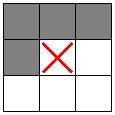

Why don't we use the blank pixels in the figure to predict pixel X?

<font color=red>**Q13 - Answer**:  </font><br>
<font color=blue>
(answer here)
</font>

Thus, it is only necessary to send the prediction error, that is, the difference between the original value and the prediction value.

In [ ]:
from lab1.code.predictive_models import predictive_model_image

lenna      = cv2.imread('lab1/images/lenna.png')
lenna_gray = cv2.cvtColor(lenna, cv2.COLOR_BGR2GRAY).astype(float) # convert to gray

predictive_model_image(lenna_gray)

What kind of redundancy is exploited with the previous predictive model example? In which parts of the image are the most significant errors concentrated? Why?

<font color=red>**Q14 - Answer**:  </font><br>
<font color=blue>
(answer here)
</font>

Let's consider an encoding scheme. If a predictive model is used, what information must the transmitter send to the receiver? What is the procedure that the receiver must follow to recover the original image?

<font color=red>**Q15 - Answer**:  </font><br>
<font color=blue>
(answer here)
</font>

#### 3.2.2 Audio

A simple model for predicting audio signals is to consider only the previous sample, and transmit only the prediction error
```
e (n) = s(n) - s(n-1))
```

In [ ]:
from lab1.code.predictive_models import predictive_model_speech

speech, fs = sf.read('lab1/audio/speech.wav')
speech     = speech[44000-1:100000,1]
predictive_model_speech (speech, fs)

In this scheme, there are times when the errors are large, and others, regardless of the amplitude of the signal, when they are negligible.
From looking at the figure, can you identify the reason? Is there a relationship with the voiced / unvoiced characteristics of phonemes?

<font color=red>**Q16 - Answer**:  </font><br>
<font color=blue>
(answer here)
</font>

## 4. Quantization block
### 4.1 Image

This block reduces the precision of the transform block output according to a pre-set fidelity criterion. The goal is to remove irrelevant information from the compressed representation.

The quantifier represents a range of values ​​from a sample transformed by a single value in the range. The set of output values ​​are the quantization indices. This step is responsible for the losses in the system and therefore determines the degree of compression achieved (here we are assuming scalar quantization, but it is also possible to group a set of transformed samples into a vector and perform vector quantization).

This operation is irreversible, and therefore should be omitted when lossless compression is desired.

Next, we will perform a quantization on a block of the image using different quantization steps.


In [21]:
import cv2
from scipy.fftpack import dct
from skimage.measure import shannon_entropy
import numpy as np

lenna      = cv2.imread('lab1/images/lenna.png')
lenna_gray = cv2.cvtColor(lenna, cv2.COLOR_BGR2GRAY) # convert to gray
dlenna     = lenna_gray.astype(float)

block = dlenna[129:161,99:131]
B = dct(dct(block,axis=0,norm='ortho'),axis=1,norm='ortho')

kk   = 0
err  = np.zeros(1901)
ent  = np.zeros(1901)

for ii in np.linspace(1,20,1901):
    Bq = np.round(B/ii)*ii
    err[kk] = np.sum(np.abs(B-Bq)**2)
    ent[kk] = shannon_entropy(Bq)
    kk = kk + 1

plt.plot(ent,10*np.log10(err))
plt.xlabel('Entropy')
plt.ylabel('MSE [dB]')
plt.show()


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


The figure presents the relationship between error and entropy.

The purpose of the figure is to show the impact of the quantizer on the relationship between compression rate and distortion (rate and distortion). However, since the compression calculation involves one encoding step, the compression rate will be approximated by entropy.

Discuss the relationship between the entropy of the signal and the compression rate that can be obtained by encoding it.

<font color=red>**Q17 - Answer**:  </font><br>
<font color=blue>
(answer here)
</font>

Discuss the relationship between quantization levels and the entropy of the output signal relative to the entropy of the input signal in the quantization step.

<font color=red>**Q18 - Answer**:  </font><br>
<font color=blue>
(answer here)
</font>

Discuss the relationship between compression rate and distortion (error) depending on the number of quantization levels. Hint: Remember that, quantitatively, the compression rate can be approximated by the entropy of the signal.

<font color=red>**Q19 - Answer**:  </font><br>
<font color=blue>
(answer here)
</font>

Why do you think it is important to get a small entropy value? Is it possible to achieve an arbitrarily small compression rate? Why?

<font color=red>**Q20 - Answer**:  </font><br>
<font color=blue>
(answer here)
</font>

### 4.2 Audio

To demonstrate the effects of audio quantization, we will examine two different types of quantization. The first is the quantization of the signal itself with two different types of quantizer: one uniform and the other non-uniform. The L parameter is the quantization step and should be adjusted to vary the quality (start with L = 0.01 and change the value).

In [22]:
from lab1.code.audio_functions import mulaw
import soundfile as sf

speech, fs = sf.read('lab1/audio/speech.wav')
speech     = speech[44000-1:100000,1]

L = 0.01
sq, imu = mulaw(speech, fs, L)

ModuleNotFoundError: No module named 'lab1'

In [ ]:
Audio(data=sq,  rate=fs)

In [ ]:
Audio(data=imu, rate=fs)

Which one sounds better? Note that the **imu** signal has been logarithm-transformed before quantization. Can this transformation affect perception? (Hint: think about what happens to small samples and ear sensitivity)


<font color=red>**Q21 - Answer**:  </font><br>
<font color=blue>
(answer here)
</font>

The second type of quantization will be the quantization of the prediction error. Only a uniform quantizer will be applied here. Adjust the L parameter.

In [ ]:
from lab1.code.audio_functions import quantize_error

speech, fs = sf.read('lab1/audio/speech.wav')
speech     = speech[44000-1:100000,0]

L=0.01
rs, fs = quantize_error(speech, fs, L)
Audio(data=rs,  rate=fs)

Is the quality of this signal comparable to either of the two above?

<font color=red>**Q22 - Answer**:  </font><br>
<font color=blue>
(answer here)
</font>

## 5. Entropy coding

This block produces the final bistream. The entropic encoder generates a fixed or variable length code to represent the output of the quantizer, and encodes the output according to the code. In many cases a variable length code is used: the shortest code words are assigned to the most frequent output values, minimizing code redundancy. This operation is reversible.

Next, we have generated two signals that come from two different sources. One of the sources has a Gaussian distribution, while the other has a uniform distribution. Both sources can generate nine different symbols. Then the symbols have been encoded using a Huffman encoder.

In [ ]:
!pip install huffman # Install necesssary package

In [ ]:
import pickle
import huffman

with open('lab1/random_signals.pkl', 'rb') as fd:
  rd = pickle.load(fd)
n1 = rd['n1'].squeeze()
n2 = rd['n2'].squeeze()

symbols = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4]) # Distinct data symbols appearing
x1,_ = np.histogram(n1,9)
x2,_ = np.histogram(n2,9)
N = n1.shape[0]
p1 = x1/N
p2 = x2/N
dict1 = huffman.codebook(zip(symbols,p1))
dict2 = huffman.codebook(zip(symbols,p2))

hcode1 = ''.join([dict1[ii] for ii in n1]) # Encode the data.
hcode2 = ''.join([dict2[ii] for ii in n2]) # Encode the data.

length1 = len(hcode1)
length2 = len(hcode2)

entropy1 =  -np.sum(p1 * np.log2(p1))
average_length_1 = len(hcode1)/N

entropy2 = -np.sum(p2 * np.log2(p2))
average_length_2 = len(hcode2)/N

print ('Entropy 1 = {:.2f}, Average length 1 = {:.2f}'.format(entropy1, average_length_1))
print ('Entropy 2 = {:.2f}, Average length 2 = {:.2f}'.format(entropy2, average_length_2))


From the analysis of the entropy values, identify which signal corresponds to the Gaussian distribution and which to the uniform distribution. Also compare the entropy values with the mean length. Do these values satisfy the condition
```
H(x) <= L <= H(x)+1?
```
<font color=red>**Q23 - Answer**:  </font><br>
<font color=blue>
(answer here)
</font>